# A03: Power Spectrum and Frequency Bands

**Duration**: ~60 minutes  
**Prerequisites**: A01 (Signals and Sampling), A02 (The Frequency Domain)

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the relationship between amplitude spectrum and power spectrum
- Compute Power Spectral Density (PSD) using both periodogram and Welch's method
- Explain the trade-off between frequency resolution and variance in spectral estimation
- Define and compute power in standard EEG frequency bands (delta, theta, alpha, beta, gamma)
- Convert between absolute and relative band power measures
- Use the decibel scale for visualizing power spectra

---

## Table of Contents

1. [Introduction](#1-introduction)
2. [From Amplitude to Power](#2-from-amplitude-to-power)
3. [Power Spectral Density (PSD)](#3-power-spectral-density-psd)
4. [The Periodogram and Its Limitations](#4-the-periodogram-and-its-limitations)
5. [Welch's Method](#5-welchs-method)
6. [EEG Frequency Bands](#6-eeg-frequency-bands)
7. [Band Power Extraction](#7-band-power-extraction)
8. [Comparing Conditions: Eyes Open vs Eyes Closed](#8-comparing-conditions-eyes-open-vs-eyes-closed)
9. [The Decibel Scale](#9-the-decibel-scale)
10. [Practical Example: Realistic EEG-like Signal](#10-practical-example-realistic-eeg-like-signal)
11. [Exercises](#11-exercises)
12. [Summary](#12-summary)
13. [External Resources](#external-resources)
14. [Discussion Questions](#13-discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path
from typing import Tuple, Optional

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.fft import fft, fftfreq

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.signals import generate_time_vector, generate_sine_wave
from src.spectral import compute_fft, compute_amplitude_spectrum, compute_frequency_resolution
from src.colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

print("Imports loaded ✓")

Imports loaded ✓


## 1. Introduction

In the previous notebook, we learned how the Fourier transform reveals the frequency content of signals through the **amplitude spectrum**. While amplitude tells us "how much" of each frequency is present, neuroscience research typically focuses on **power** — the squared amplitude.

Why power instead of amplitude? Power is directly related to the **energy** of oscillations. When we say "alpha power increased during eyes-closed rest," we're quantifying the energy contributed by 8-13 Hz oscillations. This physical interpretation makes power the standard measure in EEG/MEG analysis.

The **Power Spectral Density (PSD)** goes one step further by normalizing power by frequency resolution. This allows meaningful comparisons across recordings with different durations or sampling rates — essential for comparing across participants or studies.

Finally, we'll explore **frequency bands** — the canonical divisions (delta, theta, alpha, beta, gamma) that organize our understanding of neural oscillations. Computing "band power" is one of the most common analyses in cognitive neuroscience, and understanding it deeply prepares us for more sophisticated connectivity analyses.

## 2. From Amplitude to Power

The **amplitude spectrum** shows the magnitude of each frequency component. The **power spectrum** is simply the amplitude squared:

$$P(f) = |X(f)|^2$$

Why square the amplitude?
- **Physical meaning**: Power relates to energy — the rate at which energy is transferred
- **Variance interpretation**: For a signal, power at frequency $f$ equals the variance contributed by that frequency
- **Squaring amplifies differences**: A 2× amplitude difference becomes a 4× power difference

**Units**:
- If the signal is in µV (microvolts), amplitude is in µV, and power is in µV²
- Power is often reported in **decibels (dB)**: $P_{dB} = 10 \cdot \log_{10}(P)$

The distinction between **power spectrum** and **Power Spectral Density (PSD)** is subtle but important:
- Power spectrum: raw |X(f)|²
- PSD: normalized by frequency resolution (Δf), giving units of µV²/Hz

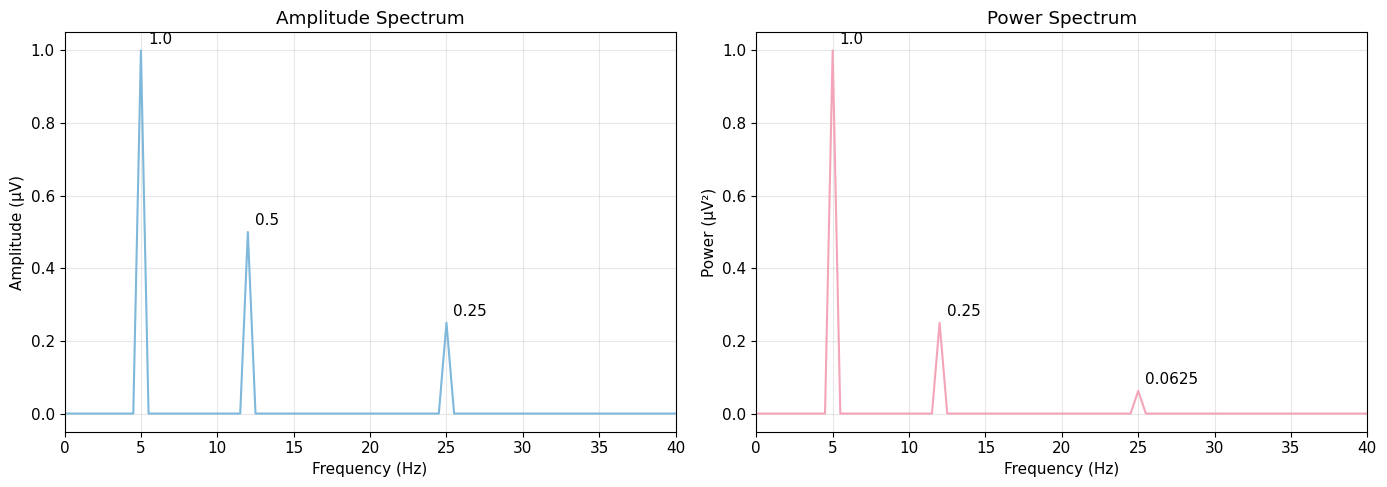

Amplitude ratios: 1.0 : 0.5 : 0.25 (linear decrease)
Power ratios:     1.0 : 0.25 : 0.0625 (squared → differences amplified)


In [2]:
# Visualization 1: Amplitude Spectrum vs Power Spectrum
# Show how squaring amplifies differences

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Create signal with components of different amplitudes
freq_1, amp_1 = 5, 1.0   # Reference amplitude
freq_2, amp_2 = 12, 0.5  # Half the amplitude
freq_3, amp_3 = 25, 0.25 # Quarter the amplitude

signal = (generate_sine_wave(t, frequency=freq_1, amplitude=amp_1) +
          generate_sine_wave(t, frequency=freq_2, amplitude=amp_2) +
          generate_sine_wave(t, frequency=freq_3, amplitude=amp_3))

# Compute amplitude spectrum
frequencies, amplitude = compute_amplitude_spectrum(signal, fs)

# Power = amplitude squared
power = amplitude ** 2

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Amplitude spectrum
axes[0].plot(frequencies, amplitude, color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude (µV)")
axes[0].set_title("Amplitude Spectrum")
axes[0].set_xlim(0, 40)
axes[0].grid(True, alpha=0.3)

# Annotate peaks with amplitude ratios
axes[0].annotate(f"1.0", (freq_1, amp_1), textcoords="offset points", xytext=(5, 5))
axes[0].annotate(f"0.5", (freq_2, amp_2), textcoords="offset points", xytext=(5, 5))
axes[0].annotate(f"0.25", (freq_3, amp_3), textcoords="offset points", xytext=(5, 5))

# Power spectrum
axes[1].plot(frequencies, power, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Power (µV²)")
axes[1].set_title("Power Spectrum")
axes[1].set_xlim(0, 40)
axes[1].grid(True, alpha=0.3)

# Annotate with power ratios
axes[1].annotate(f"1.0", (freq_1, amp_1**2), textcoords="offset points", xytext=(5, 5))
axes[1].annotate(f"0.25", (freq_2, amp_2**2), textcoords="offset points", xytext=(5, 5))
axes[1].annotate(f"0.0625", (freq_3, amp_3**2), textcoords="offset points", xytext=(5, 5))

plt.tight_layout()
plt.show()

print("Amplitude ratios: 1.0 : 0.5 : 0.25 (linear decrease)")
print("Power ratios:     1.0 : 0.25 : 0.0625 (squared → differences amplified)")

## 3. Power Spectral Density (PSD)

**Power Spectral Density** normalizes the power spectrum by the frequency resolution (Δf = fs/N):

$$S(f) = \frac{|X(f)|^2}{f_s \cdot N}$$

This normalization gives PSD the units of **µV²/Hz** — power per unit frequency. The key advantage: PSD values are comparable across recordings with different durations or sampling rates.

**Important property**: The total power in a frequency band equals the **area under the PSD curve** in that band:

$$P_{band} = \int_{f_1}^{f_2} S(f) \, df$$

This is what `scipy.signal.welch()` computes, and it's the standard representation in EEG analysis.

In [3]:
def compute_psd_fft(
    signal: NDArray[np.floating],
    fs: float,
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """Compute Power Spectral Density using FFT (periodogram).

    Parameters
    ----------
    signal : NDArray[np.floating]
        Input signal in the time domain.
    fs : float
        Sampling frequency in Hz.

    Returns
    -------
    frequencies : NDArray[np.floating]
        Array of positive frequency values in Hz.
    psd : NDArray[np.floating]
        Power Spectral Density in µV²/Hz.
    """
    n_samples = len(signal)
    
    # Compute FFT
    fft_values = fft(signal)
    frequencies = fftfreq(n_samples, 1 / fs)
    
    # Keep only positive frequencies
    positive_mask = frequencies >= 0
    frequencies_pos = frequencies[positive_mask]
    fft_pos = fft_values[positive_mask]
    
    # Compute PSD: |X|² / (fs * N), multiply by 2 for one-sided
    psd = (np.abs(fft_pos) ** 2) * 2 / (fs * n_samples)
    psd[0] /= 2  # DC component not doubled
    
    return frequencies_pos, psd

print("Function compute_psd_fft defined ✓")

Function compute_psd_fft defined ✓


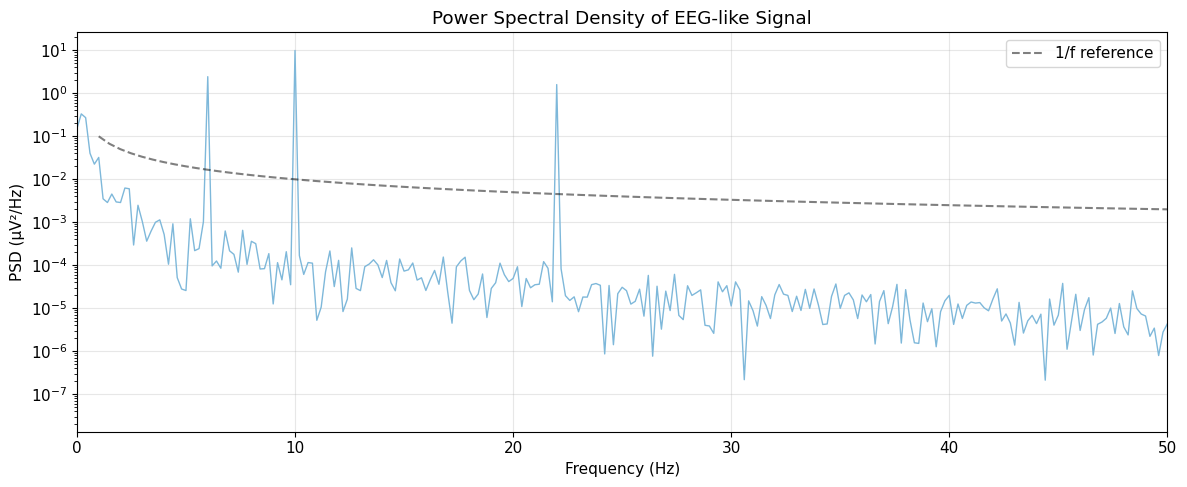

Note the characteristic 1/f trend (dashed line) — lower frequencies have more power.
The peaks at 6, 10, and 22 Hz stand out above this 1/f background.


In [4]:
# Visualization 2: PSD of EEG-like signal with 1/f trend

duration = 5.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Create EEG-like signal with neural oscillations + 1/f noise
np.random.seed(42)
alpha = generate_sine_wave(t, frequency=10, amplitude=2.0)
beta = generate_sine_wave(t, frequency=22, amplitude=0.8)
theta = generate_sine_wave(t, frequency=6, amplitude=1.0)

# 1/f noise (pink noise approximation)
white_noise = np.random.randn(len(t))
pink_noise = np.cumsum(white_noise) * 0.02

eeg_signal = alpha + beta + theta + pink_noise

# Compute PSD
frequencies, psd = compute_psd_fft(eeg_signal, fs)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.semilogy(frequencies, psd, color=COLORS["signal_1"], linewidth=1)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (µV²/Hz)")
ax.set_title("Power Spectral Density of EEG-like Signal")
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)

# Add 1/f reference line
f_ref = np.linspace(1, 50, 100)
ax.plot(f_ref, 0.1 / f_ref, "k--", alpha=0.5, label="1/f reference")
ax.legend()

plt.tight_layout()
plt.show()

print("Note the characteristic 1/f trend (dashed line) — lower frequencies have more power.")
print("The peaks at 6, 10, and 22 Hz stand out above this 1/f background.")

## 4. The Periodogram and Its Limitations

The PSD we just computed is called a **periodogram** — a single FFT-based estimate. While simple, it has serious limitations:

1. **High variance**: The periodogram is a "noisy" estimator. Even for the same underlying signal, different noise realizations produce wildly different estimates.

2. **Inconsistent**: Adding more data doesn't reduce the variance — the estimate doesn't converge!

3. **Spectral leakage**: Sharp edges in the analysis window spread energy to nearby frequencies (as we saw in A02).

Let's demonstrate the variance problem:

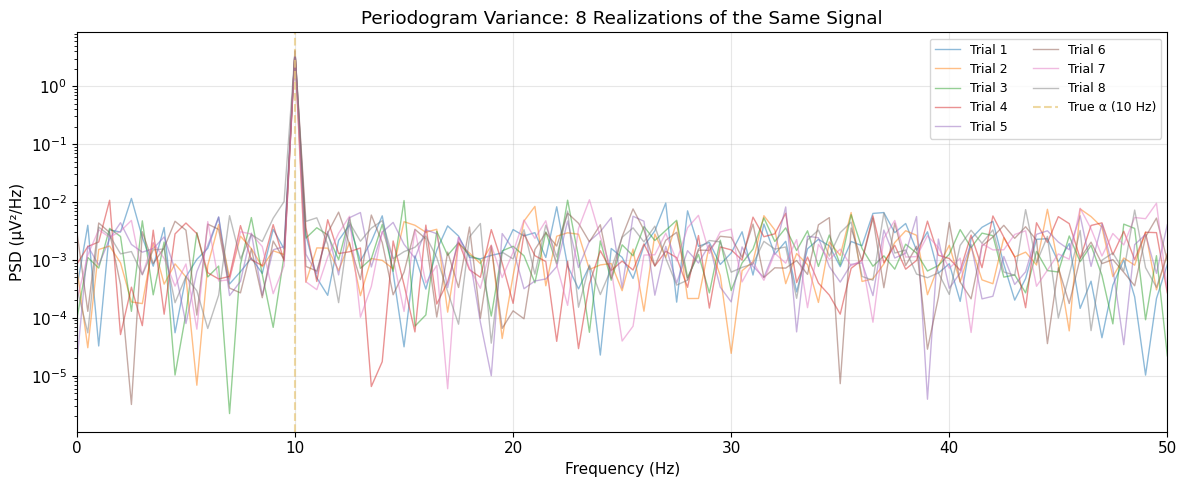

Notice how different each periodogram looks, especially away from the 10 Hz peak!
This high variance makes single periodograms unreliable for quantitative analysis.


In [5]:
# Visualization 3: Periodogram variance — multiple realizations

duration = 2.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Same underlying signal structure
alpha_freq = 10
alpha_amp = 2.0

fig, ax = plt.subplots(figsize=(12, 5))

# Generate 8 realizations with different noise
n_realizations = 8
for i in range(n_realizations):
    np.random.seed(i * 10)  # Different seed each time
    
    # Same oscillation + different noise
    signal = generate_sine_wave(t, frequency=alpha_freq, amplitude=alpha_amp)
    noise = np.random.randn(len(t)) * 0.5
    signal_noisy = signal + noise
    
    # Compute periodogram
    frequencies, psd = compute_psd_fft(signal_noisy, fs)
    
    # Plot with transparency
    ax.semilogy(frequencies, psd, alpha=0.5, linewidth=1, label=f"Trial {i+1}")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (µV²/Hz)")
ax.set_title("Periodogram Variance: 8 Realizations of the Same Signal")
ax.set_xlim(0, 50)
ax.axvline(alpha_freq, color=COLORS["signal_4"], linestyle="--", alpha=0.7, label="True α (10 Hz)")
ax.legend(loc="upper right", fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how different each periodogram looks, especially away from the 10 Hz peak!")
print("This high variance makes single periodograms unreliable for quantitative analysis.")

## 5. Welch's Method

**Welch's method** solves the periodogram's variance problem through averaging:

1. **Divide** the signal into overlapping segments
2. **Window** each segment (e.g., Hann window) to reduce spectral leakage  
3. **Compute** periodogram of each segment
4. **Average** all periodograms together

Key parameters:
- `nperseg`: Segment length — controls frequency resolution (Δf = fs / nperseg)
- `noverlap`: Overlap between segments — typically 50%
- `window`: Window function — Hann is a good default

**Trade-off**: Longer segments → better frequency resolution but fewer segments to average → more variance.

In [6]:
def compute_psd_welch(
    signal: NDArray[np.floating],
    fs: float,
    nperseg: Optional[int] = None,
    noverlap: Optional[int] = None,
    window: str = "hann",
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """Compute Power Spectral Density using Welch's method.

    Parameters
    ----------
    signal : NDArray[np.floating]
        Input signal in the time domain.
    fs : float
        Sampling frequency in Hz.
    nperseg : Optional[int]
        Length of each segment. Default: fs * 2 (0.5 Hz resolution).
    noverlap : Optional[int]
        Overlap between segments. Default: nperseg // 2 (50%).
    window : str
        Window function to apply. Default: "hann".

    Returns
    -------
    frequencies : NDArray[np.floating]
        Array of frequency values in Hz.
    psd : NDArray[np.floating]
        Power Spectral Density in µV²/Hz.
    """
    if nperseg is None:
        nperseg = int(fs * 2)  # 2 seconds → 0.5 Hz resolution
    if noverlap is None:
        noverlap = nperseg // 2  # 50% overlap
    
    frequencies, psd = welch(signal, fs=fs, nperseg=nperseg, 
                              noverlap=noverlap, window=window)
    return frequencies, psd

print("Function compute_psd_welch defined ✓")

Function compute_psd_welch defined ✓


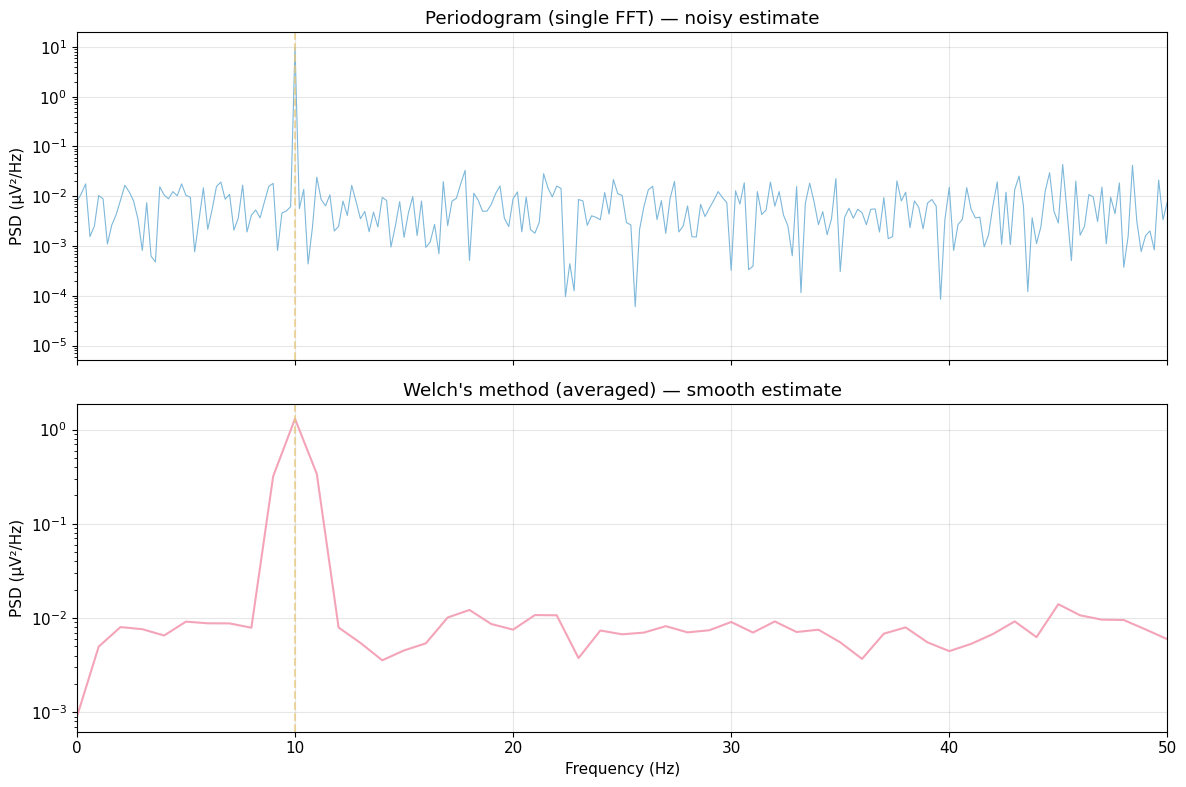

Welch's method produces a much smoother, more reliable estimate!


In [7]:
# Visualization 4: Periodogram vs Welch comparison

duration = 5.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Create noisy signal with alpha oscillation
np.random.seed(42)
signal = generate_sine_wave(t, frequency=10, amplitude=2.0)
noise = np.random.randn(len(t)) * 1.0
signal_noisy = signal + noise

# Compute both estimates
freq_periodo, psd_periodo = compute_psd_fft(signal_noisy, fs)
freq_welch, psd_welch = compute_psd_welch(signal_noisy, fs, nperseg=256)

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Periodogram
axes[0].semilogy(freq_periodo, psd_periodo, color=COLORS["signal_1"], linewidth=0.8)
axes[0].set_ylabel("PSD (µV²/Hz)")
axes[0].set_title("Periodogram (single FFT) — noisy estimate")
axes[0].set_xlim(0, 50)
axes[0].axvline(10, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[0].grid(True, alpha=0.3)

# Welch
axes[1].semilogy(freq_welch, psd_welch, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("PSD (µV²/Hz)")
axes[1].set_title("Welch's method (averaged) — smooth estimate")
axes[1].set_xlim(0, 50)
axes[1].axvline(10, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Welch's method produces a much smoother, more reliable estimate!")

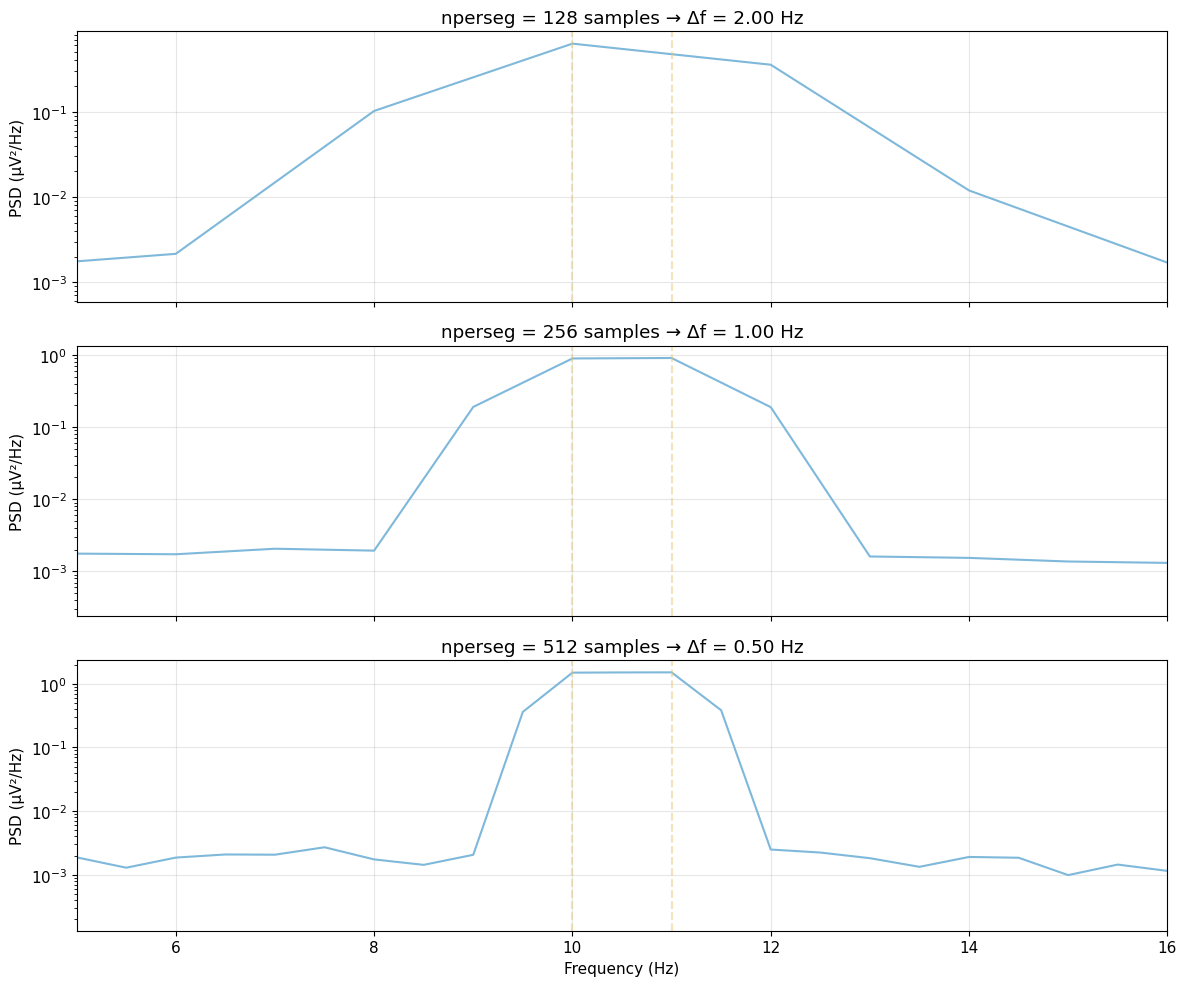

Trade-off:
  - Short segments (128): smooth but can't resolve 10 Hz from 11 Hz
  - Long segments (512): resolves peaks but noisier estimate


In [8]:
# Visualization 5: Effect of segment length on Welch estimate

duration = 10.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Create signal with two close frequencies
np.random.seed(42)
signal = (generate_sine_wave(t, frequency=10, amplitude=1.5) +
          generate_sine_wave(t, frequency=11, amplitude=1.5) +  # Only 1 Hz apart!
          np.random.randn(len(t)) * 0.5)

# Different segment lengths
nperseg_values = [128, 256, 512]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for ax, nperseg in zip(axes, nperseg_values):
    freq_resolution = fs / nperseg
    freq, psd = compute_psd_welch(signal, fs, nperseg=nperseg)
    
    ax.semilogy(freq, psd, color=COLORS["signal_1"], linewidth=1.5)
    ax.set_ylabel("PSD (µV²/Hz)")
    ax.set_title(f"nperseg = {nperseg} samples → Δf = {freq_resolution:.2f} Hz")
    ax.set_xlim(5, 16)
    ax.axvline(10, color=COLORS["signal_4"], linestyle="--", alpha=0.5)
    ax.axvline(11, color=COLORS["signal_4"], linestyle="--", alpha=0.5)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

print("Trade-off:")
print("  - Short segments (128): smooth but can't resolve 10 Hz from 11 Hz")
print("  - Long segments (512): resolves peaks but noisier estimate")

## 6. EEG Frequency Bands

Neural oscillations are traditionally organized into **frequency bands**, each associated with different cognitive states:

| Band | Frequency Range | Associated States |
|------|-----------------|-------------------|
| **Delta** (δ) | 1–4 Hz | Deep sleep, pathology |
| **Theta** (θ) | 4–8 Hz | Drowsiness, memory encoding |
| **Alpha** (α) | 8–13 Hz | Relaxed wakefulness, eyes closed |
| **Beta** (β) | 13–30 Hz | Active thinking, motor planning |
| **Gamma** (γ) | 30–100 Hz | Cognitive processing, feature binding |

These boundaries are somewhat arbitrary (you'll see slight variations in the literature), but they're widely adopted conventions.

In [9]:
# Define standard EEG frequency bands
EEG_BANDS: dict[str, tuple[float, float]] = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta": (13.0, 30.0),
    "gamma": (30.0, 100.0),
}

# Colors for each band - use COLORS from style guide
BAND_COLORS: dict[str, str] = {
    band: COLORS[band] for band in EEG_BANDS.keys()
}

print("EEG_BANDS defined:")
for band, (f_low, f_high) in EEG_BANDS.items():
    print(f"  {band}: {f_low}–{f_high} Hz")

EEG_BANDS defined:
  delta: 1.0–4.0 Hz
  theta: 4.0–8.0 Hz
  alpha: 8.0–13.0 Hz
  beta: 13.0–30.0 Hz
  gamma: 30.0–100.0 Hz


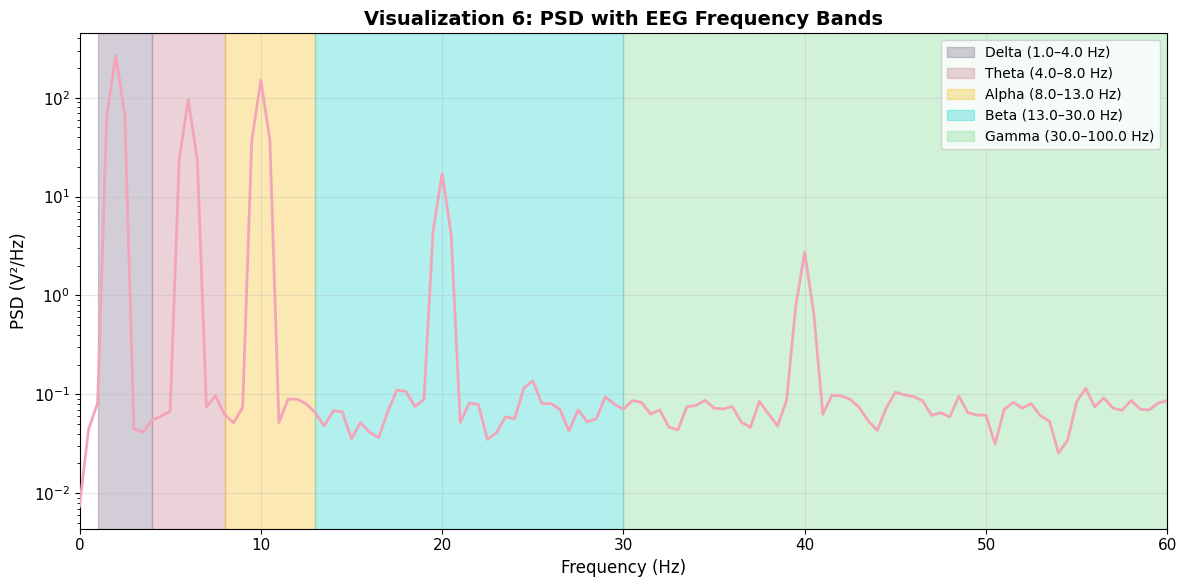

Note: Each peak corresponds to a sinusoidal component we added.
The alpha band (10 Hz) shows a prominent peak, typical of relaxed wakefulness.


In [10]:
# ============================================================================
# VISUALIZATION 6: PSD with Shaded Frequency Bands
# ============================================================================
# Create a composite signal with activity in multiple frequency bands

fs = 256  # Typical EEG sampling rate
duration = 10.0
t = generate_time_vector(duration, fs)

# Create signal with components in different bands
np.random.seed(42)
signal_delta = 20 * np.sin(2 * np.pi * 2 * t)      # Delta: 2 Hz, high amplitude
signal_theta = 12 * np.sin(2 * np.pi * 6 * t)      # Theta: 6 Hz
signal_alpha = 15 * np.sin(2 * np.pi * 10 * t)     # Alpha: 10 Hz (dominant)
signal_beta = 5 * np.sin(2 * np.pi * 20 * t)       # Beta: 20 Hz, lower amplitude
signal_gamma = 2 * np.sin(2 * np.pi * 40 * t)      # Gamma: 40 Hz, smallest
noise = 3 * np.random.randn(len(t))

composite_signal = signal_delta + signal_theta + signal_alpha + signal_beta + signal_gamma + noise

# Compute PSD using Welch's method
freqs_welch, psd_welch = compute_psd_welch(composite_signal, fs, nperseg=fs*2)

# Plot PSD with shaded frequency bands
fig, ax = plt.subplots(figsize=(12, 6))

# Plot PSD line
ax.semilogy(freqs_welch, psd_welch, color=COLORS["signal_2"], linewidth=2, zorder=5)

# Shade each frequency band
for band_name, (f_low, f_high) in EEG_BANDS.items():
    color = BAND_COLORS[band_name]
    ax.axvspan(f_low, min(f_high, 60), alpha=0.3, color=color, label=f"{band_name.capitalize()} ({f_low}–{f_high} Hz)")

ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("PSD (V²/Hz)", fontsize=12)
ax.set_title("Visualization 6: PSD with EEG Frequency Bands", fontsize=14, fontweight="bold")
ax.set_xlim(0, 60)
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Each peak corresponds to a sinusoidal component we added.")
print("The alpha band (10 Hz) shows a prominent peak, typical of relaxed wakefulness.")

## 7. Band Power Extraction

Now that we can visualize frequency bands, we need to **quantify** the power in each band.

### 7.1 Absolute Band Power

The **absolute band power** is the integral of the PSD over a frequency range:

$$P_{band} = \int_{f_{low}}^{f_{high}} S(f) \, df$$

In practice, with discrete frequencies, we approximate this using the **trapezoidal rule**:

$$P_{band} \approx \sum_{i} \frac{S(f_i) + S(f_{i+1})}{2} \cdot \Delta f$$

where $\Delta f$ is the frequency resolution.

### 7.2 Relative Band Power

**Relative band power** expresses each band as a proportion of the total power:

$$P_{relative} = \frac{P_{band}}{P_{total}} \times 100\%$$

This is useful for comparing spectral profiles across subjects or conditions, as it normalizes for overall amplitude differences.

In [11]:
def compute_band_power(
    psd: NDArray[np.floating],
    freqs: NDArray[np.floating],
    freq_range: tuple[float, float],
) -> float:
    """
    Compute the power in a specific frequency band using trapezoidal integration.
    
    Parameters
    ----------
    psd : NDArray[np.floating]
        Power spectral density values.
    freqs : NDArray[np.floating]
        Frequency values corresponding to PSD.
    freq_range : tuple[float, float]
        Tuple of (low_freq, high_freq) defining the band.
        
    Returns
    -------
    float
        Total power in the specified frequency band.
        
    Examples
    --------
    >>> freqs = np.array([0, 1, 2, 3, 4, 5])
    >>> psd = np.array([1, 1, 1, 1, 1, 1])
    >>> compute_band_power(psd, freqs, (1, 4))  # Power from 1-4 Hz
    3.0
    """
    f_low, f_high = freq_range
    
    # Find indices within the frequency range
    band_mask = (freqs >= f_low) & (freqs <= f_high)
    freqs_band = freqs[band_mask]
    psd_band = psd[band_mask]
    
    if len(freqs_band) < 2:
        return 0.0
    
    # Trapezoidal integration
    band_power = np.trapz(psd_band, freqs_band)
    
    return float(band_power)


def compute_all_band_powers(
    psd: NDArray[np.floating],
    freqs: NDArray[np.floating],
    bands: dict[str, tuple[float, float]] | None = None,
) -> dict[str, float]:
    """
    Compute absolute power for all frequency bands.
    
    Parameters
    ----------
    psd : NDArray[np.floating]
        Power spectral density values.
    freqs : NDArray[np.floating]
        Frequency values corresponding to PSD.
    bands : dict[str, tuple[float, float]] | None, optional
        Dictionary mapping band names to (low_freq, high_freq) tuples.
        If None, uses standard EEG bands.
        
    Returns
    -------
    dict[str, float]
        Dictionary mapping band names to their absolute power values.
        
    Examples
    --------
    >>> freqs, psd = compute_psd_welch(signal, fs=256)
    >>> powers = compute_all_band_powers(psd, freqs)
    >>> print(powers["alpha"])
    """
    if bands is None:
        bands = {
            "delta": (1.0, 4.0),
            "theta": (4.0, 8.0),
            "alpha": (8.0, 13.0),
            "beta": (13.0, 30.0),
            "gamma": (30.0, 100.0),
        }
    
    band_powers = {}
    for band_name, freq_range in bands.items():
        band_powers[band_name] = compute_band_power(psd, freqs, freq_range)
    
    return band_powers


def compute_relative_band_power(
    psd: NDArray[np.floating],
    freqs: NDArray[np.floating],
    freq_range: tuple[float, float],
    total_range: tuple[float, float] = (1.0, 100.0),
) -> float:
    """
    Compute the relative power of a frequency band as a percentage of total power.
    
    Parameters
    ----------
    psd : NDArray[np.floating]
        Power spectral density values.
    freqs : NDArray[np.floating]
        Frequency values corresponding to PSD.
    freq_range : tuple[float, float]
        Tuple of (low_freq, high_freq) defining the band of interest.
    total_range : tuple[float, float], optional
        Frequency range for computing total power. Default is (1, 100) Hz.
        
    Returns
    -------
    float
        Relative power as a percentage (0-100).
        
    Examples
    --------
    >>> freqs, psd = compute_psd_welch(signal, fs=256)
    >>> alpha_relative = compute_relative_band_power(psd, freqs, (8, 13))
    >>> print(f"Alpha: {alpha_relative:.1f}%")
    """
    band_power = compute_band_power(psd, freqs, freq_range)
    total_power = compute_band_power(psd, freqs, total_range)
    
    if total_power == 0:
        return 0.0
    
    return 100.0 * band_power / total_power


# Test the functions
band_powers = compute_all_band_powers(psd_welch, freqs_welch, EEG_BANDS)

print("Absolute Band Powers:")
for band, power in band_powers.items():
    print(f"  {band.capitalize():8s}: {power:10.2f} V²")

print("\nRelative Band Powers:")
total_power = sum(band_powers.values())
for band, power in band_powers.items():
    relative = 100 * power / total_power
    print(f"  {band.capitalize():8s}: {relative:6.1f}%")

Absolute Band Powers:
  Delta   :     198.92 V²
  Theta   :      71.54 V²
  Alpha   :     112.43 V²
  Beta    :      13.93 V²
  Gamma   :       6.88 V²

Relative Band Powers:
  Delta   :   49.3%
  Theta   :   17.7%
  Alpha   :   27.8%
  Beta    :    3.5%
  Gamma   :    1.7%


/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/1703510758.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd_band, freqs_band)


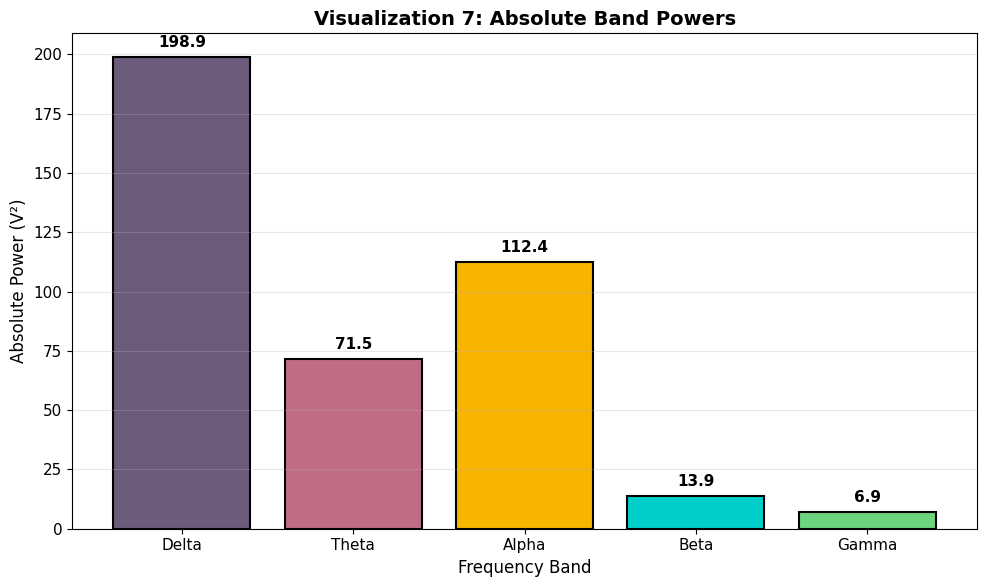

Note: Delta and alpha bands show high power due to their large-amplitude components.


In [12]:
# ============================================================================
# VISUALIZATION 7: Absolute Band Powers (Bar Chart)
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

band_names = list(band_powers.keys())
powers = list(band_powers.values())
colors = [BAND_COLORS[band] for band in band_names]

bars = ax.bar(
    [name.capitalize() for name in band_names], 
    powers, 
    color=colors,
    edgecolor="black",
    linewidth=1.5,
)

# Add value labels on bars
for bar, power in zip(bars, powers):
    height = bar.get_height()
    ax.annotate(
        f"{power:.1f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

ax.set_xlabel("Frequency Band", fontsize=12)
ax.set_ylabel("Absolute Power (V²)", fontsize=12)
ax.set_title("Visualization 7: Absolute Band Powers", fontsize=14, fontweight="bold")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Delta and alpha bands show high power due to their large-amplitude components.")

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/1703510758.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd_band, freqs_band)


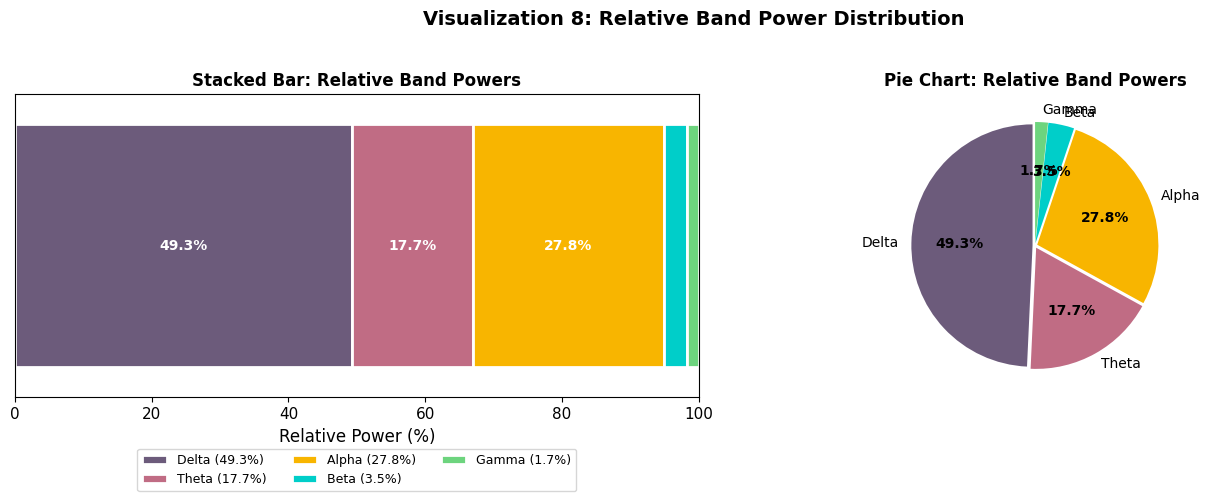

Relative power normalizes for overall amplitude, useful for comparing across subjects.


In [13]:
# ============================================================================
# VISUALIZATION 8: Relative Band Powers (Stacked Bar + Pie Chart)
# ============================================================================

# Compute relative powers
relative_powers = {}
for band, freq_range in EEG_BANDS.items():
    relative_powers[band] = compute_relative_band_power(
        psd_welch, freqs_welch, freq_range, total_range=(1.0, 100.0)
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked horizontal bar
ax1 = axes[0]
left = 0
for band in band_names:
    width = relative_powers[band]
    ax1.barh(
        0, 
        width, 
        left=left, 
        color=BAND_COLORS[band], 
        edgecolor="white",
        linewidth=2,
        label=f"{band.capitalize()} ({width:.1f}%)"
    )
    # Add label in the middle of each segment if wide enough
    if width > 5:
        ax1.text(
            left + width / 2, 
            0, 
            f"{width:.1f}%",
            ha="center", 
            va="center", 
            fontsize=10,
            fontweight="bold",
            color="white",
        )
    left += width

ax1.set_xlim(0, 100)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel("Relative Power (%)", fontsize=12)
ax1.set_yticks([])
ax1.set_title("Stacked Bar: Relative Band Powers", fontsize=12, fontweight="bold")
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9)

# Right: Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    [relative_powers[band] for band in band_names],
    labels=[band.capitalize() for band in band_names],
    colors=[BAND_COLORS[band] for band in band_names],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.02] * len(band_names),
    textprops={"fontsize": 10},
)
for autotext in autotexts:
    autotext.set_fontweight("bold")
ax2.set_title("Pie Chart: Relative Band Powers", fontsize=12, fontweight="bold")

plt.suptitle("Visualization 8: Relative Band Power Distribution", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("Relative power normalizes for overall amplitude, useful for comparing across subjects.")

## 8. Comparing Conditions: Eyes Open vs Eyes Closed

One of the most robust findings in EEG research is the **alpha enhancement** when closing the eyes.

### The Alpha Rhythm

- **Eyes open**: Visual processing engages occipital cortex → alpha is suppressed
- **Eyes closed**: Visual cortex "idles" → alpha power increases dramatically (especially at 8-12 Hz)

This phenomenon, discovered by Hans Berger in 1929, remains a fundamental marker of cortical state.

### Practical Application

Comparing band powers between conditions allows us to:
1. Detect state changes (alertness, relaxation, cognitive load)
2. Identify task-related spectral modulations
3. Establish baselines for neurofeedback protocols

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/1703510758.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd_band, freqs_band)


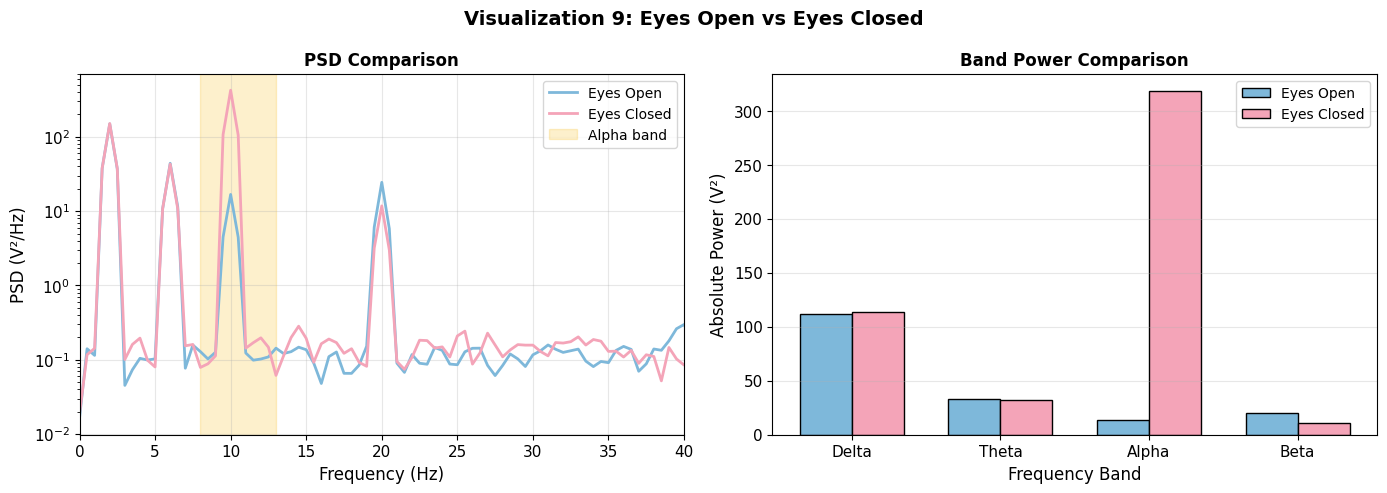

Alpha power ratio (Closed/Open): 24.0x
This dramatic alpha increase is the hallmark of the 'eyes closed' state.


In [14]:
# ============================================================================
# VISUALIZATION 9: Eyes Open vs Eyes Closed - PSD Comparison
# ============================================================================
# Simulate two conditions with different alpha levels

fs = 256
duration = 10.0
t = generate_time_vector(duration, fs)
np.random.seed(123)

# Common components (same in both conditions)
delta_component = 15 * np.sin(2 * np.pi * 2 * t)
theta_component = 8 * np.sin(2 * np.pi * 6 * t)
beta_component = 4 * np.sin(2 * np.pi * 20 * t)

# Eyes OPEN: suppressed alpha, more beta (active processing)
alpha_open = 5 * np.sin(2 * np.pi * 10 * t)
noise_open = 4 * np.random.randn(len(t))
signal_eyes_open = delta_component + theta_component + alpha_open + beta_component * 1.5 + noise_open

# Eyes CLOSED: enhanced alpha (idling visual cortex)
alpha_closed = 25 * np.sin(2 * np.pi * 10 * t)  # Much stronger alpha!
noise_closed = 4 * np.random.randn(len(t))
signal_eyes_closed = delta_component + theta_component + alpha_closed + beta_component + noise_closed

# Compute PSDs
freqs_open, psd_open = compute_psd_welch(signal_eyes_open, fs, nperseg=fs*2)
freqs_closed, psd_closed = compute_psd_welch(signal_eyes_closed, fs, nperseg=fs*2)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overlay PSDs
ax1 = axes[0]
ax1.semilogy(freqs_open, psd_open, color=COLORS["signal_1"], linewidth=2, label="Eyes Open")
ax1.semilogy(freqs_closed, psd_closed, color=COLORS["signal_2"], linewidth=2, label="Eyes Closed")

# Highlight alpha band
ax1.axvspan(8, 13, alpha=0.2, color=BAND_COLORS["alpha"], label="Alpha band")

ax1.set_xlabel("Frequency (Hz)", fontsize=12)
ax1.set_ylabel("PSD (V²/Hz)", fontsize=12)
ax1.set_title("PSD Comparison", fontsize=12, fontweight="bold")
ax1.set_xlim(0, 40)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Band power comparison
ax2 = axes[1]

# Compute band powers for both conditions
powers_open = compute_all_band_powers(psd_open, freqs_open, EEG_BANDS)
powers_closed = compute_all_band_powers(psd_closed, freqs_closed, EEG_BANDS)

bands_to_plot = ["delta", "theta", "alpha", "beta"]
x = np.arange(len(bands_to_plot))
width = 0.35

bars_open = ax2.bar(
    x - width/2, 
    [powers_open[b] for b in bands_to_plot],
    width, 
    label="Eyes Open", 
    color=COLORS["signal_1"],
    edgecolor="black",
)
bars_closed = ax2.bar(
    x + width/2, 
    [powers_closed[b] for b in bands_to_plot],
    width, 
    label="Eyes Closed", 
    color=COLORS["signal_2"],
    edgecolor="black",
)

ax2.set_xlabel("Frequency Band", fontsize=12)
ax2.set_ylabel("Absolute Power (V²)", fontsize=12)
ax2.set_title("Band Power Comparison", fontsize=12, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels([b.capitalize() for b in bands_to_plot])
ax2.legend(fontsize=10)
ax2.grid(True, axis="y", alpha=0.3)

plt.suptitle("Visualization 9: Eyes Open vs Eyes Closed", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print alpha enhancement
alpha_ratio = powers_closed["alpha"] / powers_open["alpha"]
print(f"Alpha power ratio (Closed/Open): {alpha_ratio:.1f}x")
print("This dramatic alpha increase is the hallmark of the 'eyes closed' state.")

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/1703510758.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd_band, freqs_band)


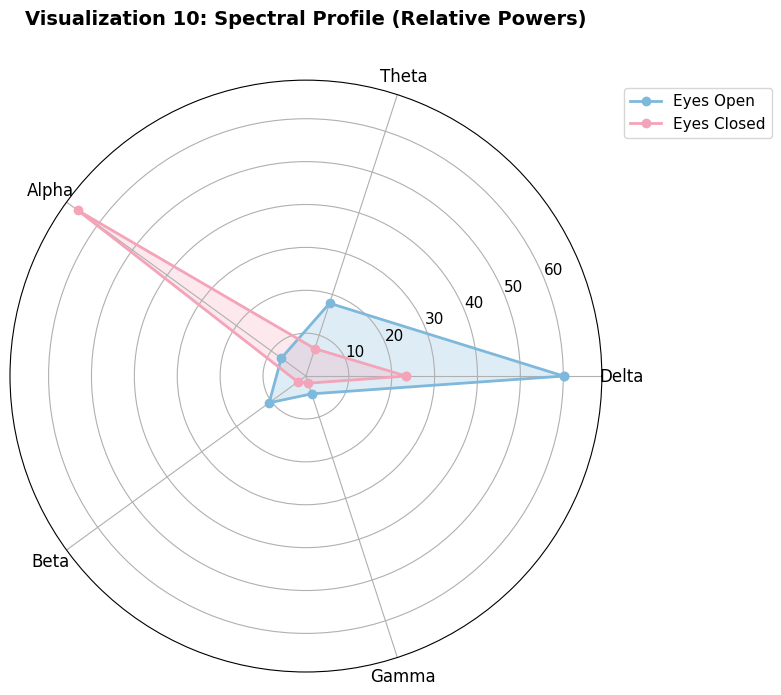

The radar chart clearly shows the shift toward alpha dominance with eyes closed.


In [15]:
# ============================================================================
# VISUALIZATION 10: Spectral Profile Change (Radar Chart)
# ============================================================================
# Show relative power distribution as a radar/spider chart

from matplotlib.patches import Patch

# Compute relative powers for both conditions
relative_open = {}
relative_closed = {}
for band, freq_range in EEG_BANDS.items():
    relative_open[band] = compute_relative_band_power(psd_open, freqs_open, freq_range)
    relative_closed[band] = compute_relative_band_power(psd_closed, freqs_closed, freq_range)

# Prepare data for radar chart
bands_radar = ["delta", "theta", "alpha", "beta", "gamma"]
values_open = [relative_open[b] for b in bands_radar]
values_closed = [relative_closed[b] for b in bands_radar]

# Close the polygon
values_open += values_open[:1]
values_closed += values_closed[:1]

# Compute angles
angles = np.linspace(0, 2 * np.pi, len(bands_radar), endpoint=False).tolist()
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values_open, "o-", linewidth=2, color=COLORS["signal_1"], label="Eyes Open")
ax.fill(angles, values_open, alpha=0.25, color=COLORS["signal_1"])

ax.plot(angles, values_closed, "o-", linewidth=2, color=COLORS["signal_2"], label="Eyes Closed")
ax.fill(angles, values_closed, alpha=0.25, color=COLORS["signal_2"])

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels([b.capitalize() for b in bands_radar], fontsize=12)

ax.set_title("Visualization 10: Spectral Profile (Relative Powers)", fontsize=14, fontweight="bold", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=11)

plt.tight_layout()
plt.show()

print("The radar chart clearly shows the shift toward alpha dominance with eyes closed.")

## 9. The Decibel Scale

Power values in EEG can span several orders of magnitude. The **decibel (dB)** scale compresses this range for better visualization and interpretation.

### Why Use Decibels?

1. **Dynamic range compression**: Power ratios of 1,000,000:1 become 60 dB
2. **Perceptual relevance**: Our senses respond logarithmically to stimuli
3. **Additive comparisons**: Multiplying powers = adding dB values

### The Formula

$$P_{dB} = 10 \cdot \log_{10}\left(\frac{P}{P_{ref}}\right)$$

where:
- $P$ is the power value
- $P_{ref}$ is the reference power (often 1 or the minimum non-zero value)

**Key relationships:**
- Doubling power ≈ +3 dB
- 10× power = +10 dB
- 100× power = +20 dB

In [16]:
def power_to_db(
    power: NDArray[np.floating],
    ref: float | None = None,
    min_db: float = -100.0,
) -> NDArray[np.floating]:
    """
    Convert power values to decibels (dB).
    
    Parameters
    ----------
    power : NDArray[np.floating]
        Power values to convert.
    ref : float | None, optional
        Reference power value. If None, uses the maximum power value.
        Common choices: 1.0 (absolute), max(power) (relative to peak).
    min_db : float, optional
        Minimum dB value to return (clips very small values). Default is -100.
        
    Returns
    -------
    NDArray[np.floating]
        Power values in decibels.
        
    Examples
    --------
    >>> power = np.array([1, 10, 100, 1000])
    >>> power_to_db(power, ref=1.0)
    array([ 0., 10., 20., 30.])
    
    Notes
    -----
    - Uses 10*log10 (power ratio), not 20*log10 (amplitude ratio)
    - Zero or negative power values are clipped to min_db
    """
    power = np.asarray(power, dtype=np.float64)
    
    if ref is None:
        ref = np.max(power)
    
    # Avoid log of zero or negative values
    power_safe = np.maximum(power, np.finfo(float).tiny)
    
    db_values = 10.0 * np.log10(power_safe / ref)
    
    # Clip to minimum dB
    db_values = np.maximum(db_values, min_db)
    
    return db_values


# Demonstrate dB conversion
print("Power to dB conversion examples:")
test_powers = np.array([1, 2, 10, 100, 1000])
test_db = power_to_db(test_powers, ref=1.0)
for p, db in zip(test_powers, test_db):
    print(f"  {p:4d} → {db:5.1f} dB")

print("\nKey insight: Each 10× increase in power = +10 dB")

Power to dB conversion examples:
     1 →   0.0 dB
     2 →   3.0 dB
    10 →  10.0 dB
   100 →  20.0 dB
  1000 →  30.0 dB

Key insight: Each 10× increase in power = +10 dB


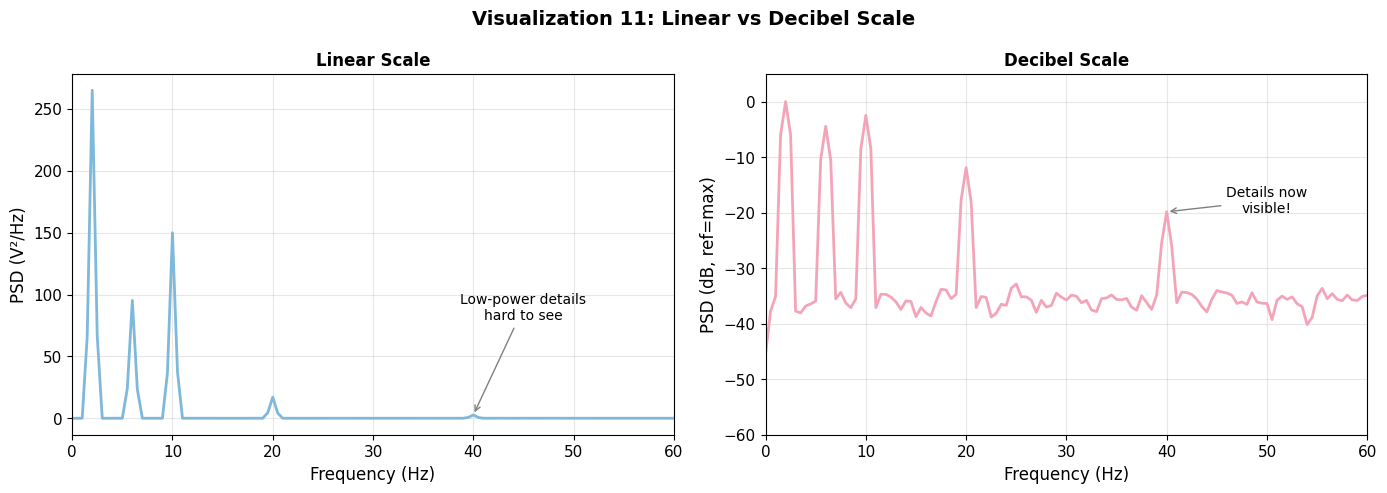

The dB scale reveals structure across the full dynamic range.


In [17]:
# ============================================================================
# VISUALIZATION 11: PSD in Linear vs Decibel Scale
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Use the composite signal PSD from earlier
psd_db = power_to_db(psd_welch, ref=np.max(psd_welch))

# Left: Linear scale
ax1 = axes[0]
ax1.plot(freqs_welch, psd_welch, color=COLORS["signal_1"], linewidth=2)
ax1.set_xlabel("Frequency (Hz)", fontsize=12)
ax1.set_ylabel("PSD (V²/Hz)", fontsize=12)
ax1.set_title("Linear Scale", fontsize=12, fontweight="bold")
ax1.set_xlim(0, 60)
ax1.grid(True, alpha=0.3)

# Annotate: low power regions are barely visible
ax1.annotate(
    "Low-power details\nhard to see",
    xy=(40, psd_welch[np.argmin(np.abs(freqs_welch - 40))]),
    xytext=(45, np.max(psd_welch) * 0.3),
    fontsize=10,
    arrowprops=dict(arrowstyle="->", color="gray"),
    ha="center",
)

# Right: Decibel scale
ax2 = axes[1]
ax2.plot(freqs_welch, psd_db, color=COLORS["signal_2"], linewidth=2)
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("PSD (dB, ref=max)", fontsize=12)
ax2.set_title("Decibel Scale", fontsize=12, fontweight="bold")
ax2.set_xlim(0, 60)
ax2.set_ylim(-60, 5)
ax2.grid(True, alpha=0.3)

# Annotate: now details are visible
ax2.annotate(
    "Details now\nvisible!",
    xy=(40, psd_db[np.argmin(np.abs(freqs_welch - 40))]),
    xytext=(50, -20),
    fontsize=10,
    arrowprops=dict(arrowstyle="->", color="gray"),
    ha="center",
)

plt.suptitle("Visualization 11: Linear vs Decibel Scale", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("The dB scale reveals structure across the full dynamic range.")

## 10. Practical Example: Realistic EEG-like Signal

Real EEG signals have a characteristic **1/f spectrum** (pink noise) with superimposed oscillatory activity. Let's create and analyze a realistic synthetic EEG signal.

### Components of Real EEG:
1. **1/f background**: Power decreases with frequency (aperiodic component)
2. **Oscillatory peaks**: Alpha, beta, etc. appear as bumps on top of 1/f
3. **Noise**: Various sources add broadband noise

In [18]:
# ============================================================================
# VISUALIZATION 12: Realistic EEG Analysis Pipeline
# ============================================================================

def generate_pink_noise(n_samples: int, fs: float, seed: int | None = None) -> NDArray[np.floating]:
    """
    Generate 1/f (pink) noise using spectral synthesis.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    fs : float
        Sampling frequency in Hz.
    seed : int | None, optional
        Random seed for reproducibility.
        
    Returns
    -------
    NDArray[np.floating]
        Pink noise signal.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate white noise in frequency domain
    n_freqs = n_samples // 2 + 1
    freqs = np.fft.rfftfreq(n_samples, 1/fs)
    
    # Create 1/f magnitude spectrum (avoid division by zero)
    freqs_safe = np.where(freqs == 0, 1, freqs)
    magnitude = 1.0 / np.sqrt(freqs_safe)
    magnitude[0] = 0  # No DC component
    
    # Random phases
    phases = np.random.uniform(0, 2 * np.pi, n_freqs)
    
    # Construct spectrum and inverse FFT
    spectrum = magnitude * np.exp(1j * phases)
    pink = np.fft.irfft(spectrum, n_samples)
    
    # Normalize
    pink = pink / np.std(pink)
    
    return pink


# Create a realistic EEG-like signal
fs = 256
duration = 30.0  # 30 seconds of data
t = generate_time_vector(duration, fs)
n_samples = len(t)

np.random.seed(42)

# 1. Pink noise background (1/f)
pink_noise = 10 * generate_pink_noise(n_samples, fs, seed=42)

# 2. Alpha oscillation (10 Hz) - the dominant rhythm
alpha_amplitude = 8
alpha_freq = 10
# Add some amplitude modulation for realism
alpha_envelope = 1 + 0.3 * np.sin(2 * np.pi * 0.2 * t)  # Slow modulation
alpha_osc = alpha_amplitude * alpha_envelope * np.sin(2 * np.pi * alpha_freq * t)

# 3. Beta oscillation (20 Hz) - smaller amplitude
beta_osc = 3 * np.sin(2 * np.pi * 20 * t)

# 4. Theta burst (6 Hz) - intermittent
theta_burst = np.zeros_like(t)
burst_start = int(10 * fs)  # Start at 10 seconds
burst_end = int(15 * fs)    # End at 15 seconds
theta_burst[burst_start:burst_end] = 12 * np.sin(2 * np.pi * 6 * t[burst_start:burst_end])

# 5. White noise (measurement noise)
white_noise = 2 * np.random.randn(n_samples)

# Combine all components
eeg_signal = pink_noise + alpha_osc + beta_osc + theta_burst + white_noise

print(f"Generated {duration}s of realistic EEG-like data at {fs} Hz")

Generated 30.0s of realistic EEG-like data at 256 Hz


/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/1703510758.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd_band, freqs_band)
/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_34619/3934509928.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


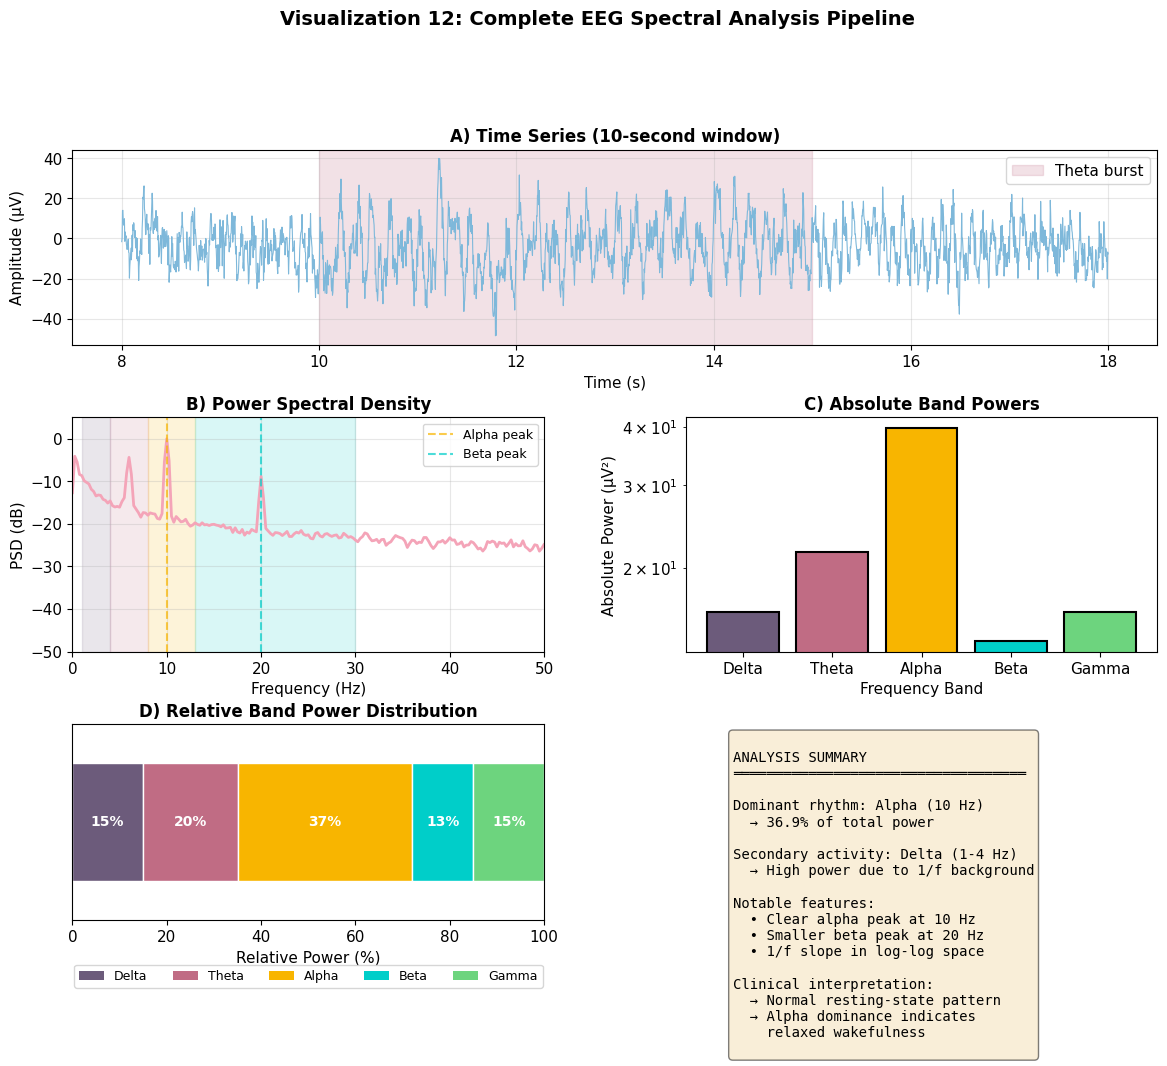

In [19]:
# Complete analysis pipeline visualization
fig = plt.figure(figsize=(14, 10))

# Create grid for subplots
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1], hspace=0.35, wspace=0.3)

# ---- Row 1: Time series ----
ax1 = fig.add_subplot(gs[0, :])
time_window = (8, 18)  # Show 10 seconds including theta burst
mask = (t >= time_window[0]) & (t <= time_window[1])
ax1.plot(t[mask], eeg_signal[mask], color=COLORS["signal_1"], linewidth=0.8)
ax1.axvspan(10, 15, alpha=0.2, color=BAND_COLORS["theta"], label="Theta burst")
ax1.set_xlabel("Time (s)", fontsize=11)
ax1.set_ylabel("Amplitude (µV)", fontsize=11)
ax1.set_title("A) Time Series (10-second window)", fontsize=12, fontweight="bold")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# ---- Row 2: PSD with bands ----
ax2 = fig.add_subplot(gs[1, 0])

# Compute PSD
freqs_eeg, psd_eeg = compute_psd_welch(eeg_signal, fs, nperseg=fs*4)
psd_eeg_db = power_to_db(psd_eeg, ref=np.max(psd_eeg))

ax2.plot(freqs_eeg, psd_eeg_db, color=COLORS["signal_2"], linewidth=2)

# Shade frequency bands
for band_name, (f_low, f_high) in EEG_BANDS.items():
    if f_high <= 50:  # Only show up to 50 Hz
        ax2.axvspan(f_low, f_high, alpha=0.15, color=BAND_COLORS[band_name])

# Mark peaks
ax2.axvline(10, color=BAND_COLORS["alpha"], linestyle="--", alpha=0.7, label="Alpha peak")
ax2.axvline(20, color=BAND_COLORS["beta"], linestyle="--", alpha=0.7, label="Beta peak")

ax2.set_xlabel("Frequency (Hz)", fontsize=11)
ax2.set_ylabel("PSD (dB)", fontsize=11)
ax2.set_title("B) Power Spectral Density", fontsize=12, fontweight="bold")
ax2.set_xlim(0, 50)
ax2.set_ylim(-50, 5)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# ---- Row 2: Band powers bar chart ----
ax3 = fig.add_subplot(gs[1, 1])

band_powers_eeg = compute_all_band_powers(psd_eeg, freqs_eeg, EEG_BANDS)
bands_plot = ["delta", "theta", "alpha", "beta", "gamma"]
powers_plot = [band_powers_eeg[b] for b in bands_plot]
colors_plot = [BAND_COLORS[b] for b in bands_plot]

bars = ax3.bar(
    [b.capitalize() for b in bands_plot],
    powers_plot,
    color=colors_plot,
    edgecolor="black",
    linewidth=1.5,
)
ax3.set_xlabel("Frequency Band", fontsize=11)
ax3.set_ylabel("Absolute Power (µV²)", fontsize=11)
ax3.set_title("C) Absolute Band Powers", fontsize=12, fontweight="bold")
ax3.set_yscale("log")
ax3.grid(True, axis="y", alpha=0.3)

# ---- Row 3: Relative powers ----
ax4 = fig.add_subplot(gs[2, 0])

relative_powers_eeg = {}
for band, freq_range in EEG_BANDS.items():
    relative_powers_eeg[band] = compute_relative_band_power(psd_eeg, freqs_eeg, freq_range)

# Stacked bar
left = 0
for band in bands_plot:
    width = relative_powers_eeg[band]
    ax4.barh(0, width, left=left, color=BAND_COLORS[band], edgecolor="white", height=0.6)
    if width > 8:
        ax4.text(left + width/2, 0, f"{width:.0f}%", ha="center", va="center", 
                fontsize=10, fontweight="bold", color="white")
    left += width

ax4.set_xlim(0, 100)
ax4.set_ylim(-0.5, 0.5)
ax4.set_xlabel("Relative Power (%)", fontsize=11)
ax4.set_yticks([])
ax4.set_title("D) Relative Band Power Distribution", fontsize=12, fontweight="bold")

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=BAND_COLORS[b], label=f"{b.capitalize()}") for b in bands_plot]
ax4.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=9)

# ---- Row 3: Summary text ----
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis("off")

summary_text = """
ANALYSIS SUMMARY
═══════════════════════════════════

Dominant rhythm: Alpha (10 Hz)
  → {alpha_pct:.1f}% of total power

Secondary activity: Delta (1-4 Hz)
  → High power due to 1/f background

Notable features:
  • Clear alpha peak at 10 Hz
  • Smaller beta peak at 20 Hz
  • 1/f slope in log-log space

Clinical interpretation:
  → Normal resting-state pattern
  → Alpha dominance indicates
    relaxed wakefulness
""".format(alpha_pct=relative_powers_eeg["alpha"])

ax5.text(0.1, 0.95, summary_text, transform=ax5.transAxes, fontsize=10,
        verticalalignment="top", fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.suptitle("Visualization 12: Complete EEG Spectral Analysis Pipeline", 
            fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 11. Exercises

Test your understanding with these hands-on exercises.

### 🎯 Exercise 1: Impact of Segment Length on Welch PSD

Create a signal with a 10 Hz component and compare Welch PSD estimates using different `nperseg` values (64, 256, 1024 samples). Plot all three PSDs on the same figure.

**Questions to answer:**
- How does `nperseg` affect frequency resolution?
- How does it affect variance (smoothness)?
- What is the trade-off?

In [20]:
# Exercise 1: Your code here
# ---------------------------

# Create a 10-second signal at 256 Hz with a 10 Hz component
fs_ex1 = 256
duration_ex1 = 10.0
t_ex1 = generate_time_vector(duration_ex1, fs_ex1)

# Signal: 10 Hz sine + noise
signal_ex1 = 5 * np.sin(2 * np.pi * 10 * t_ex1) + np.random.randn(len(t_ex1))

# Compute Welch PSD with different nperseg values
nperseg_values = [64, 256, 1024]

# TODO: Compute PSD for each nperseg and plot

# fig, ax = plt.subplots(figsize=(10, 6))
# for nperseg in nperseg_values:
#     freqs, psd = compute_psd_welch(signal_ex1, fs_ex1, nperseg=nperseg)
#     ax.semilogy(freqs, psd, label=f"nperseg={nperseg}")
# ...



<details>
<summary><strong>💡 Solution Exercise 1</strong></summary>

```python
# Create a 10-second signal at 256 Hz with a 10 Hz component
fs_ex1 = 256
duration_ex1 = 10.0
t_ex1 = generate_time_vector(duration_ex1, fs_ex1)

# Signal: 10 Hz sine + noise
signal_ex1 = 5 * np.sin(2 * np.pi * 10 * t_ex1) + np.random.randn(len(t_ex1))

# Compute Welch PSD with different nperseg values
nperseg_values = [64, 256, 1024]

fig, ax = plt.subplots(figsize=(10, 6))

for nperseg in nperseg_values:
    freqs, psd = compute_psd_welch(signal_ex1, fs_ex1, nperseg=nperseg)
    freq_res = fs_ex1 / nperseg
    ax.semilogy(freqs, psd, linewidth=2, label=f"nperseg={nperseg} (Δf={freq_res:.2f} Hz)")

ax.axvline(10, color="red", linestyle="--", alpha=0.5, label="True frequency")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (V²/Hz)")
ax.set_title("Effect of nperseg on Welch PSD")
ax.set_xlim(0, 30)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("Answers:")
print("- Larger nperseg → better frequency resolution (narrower peaks)")
print("- Smaller nperseg → more averaging → smoother (lower variance)")
print("- Trade-off: resolution vs. variance reduction")
```

**Key insights:**
- `nperseg=64`: Poor resolution (Δf=4 Hz), but smooth curve
- `nperseg=1024`: Excellent resolution (Δf=0.25 Hz), but noisy
- `nperseg=256`: Good compromise for many EEG applications

</details>

### 🎯 Exercise 2: Band Power Ratio (Alpha/Beta)

The **alpha/beta ratio** is often used as an index of cortical arousal:
- High ratio → relaxed state (alpha dominant)
- Low ratio → alert/active state (beta dominant)

Create two signals simulating "relaxed" and "alert" states, compute the alpha/beta ratio for each, and visualize the difference.

In [21]:
# Exercise 2: Your code here
# ---------------------------

fs_ex2 = 256
duration_ex2 = 10.0
t_ex2 = generate_time_vector(duration_ex2, fs_ex2)

# TODO: Create "relaxed" signal (strong alpha, weak beta)
# signal_relaxed = ...

# TODO: Create "alert" signal (weak alpha, strong beta)
# signal_alert = ...

# TODO: Compute PSD and band powers for each

# TODO: Calculate alpha/beta ratio

# TODO: Visualize with a bar chart comparing the ratios



<details>
<summary><strong>💡 Solution Exercise 2</strong></summary>

```python
fs_ex2 = 256
duration_ex2 = 10.0
t_ex2 = generate_time_vector(duration_ex2, fs_ex2)
np.random.seed(42)

# "Relaxed" signal: strong alpha (10 Hz), weak beta (20 Hz)
signal_relaxed = (15 * np.sin(2 * np.pi * 10 * t_ex2) +  # Strong alpha
                  3 * np.sin(2 * np.pi * 20 * t_ex2) +   # Weak beta
                  2 * np.random.randn(len(t_ex2)))

# "Alert" signal: weak alpha, strong beta
signal_alert = (3 * np.sin(2 * np.pi * 10 * t_ex2) +    # Weak alpha
                12 * np.sin(2 * np.pi * 20 * t_ex2) +   # Strong beta
                2 * np.random.randn(len(t_ex2)))

# Compute PSDs
freqs_relaxed, psd_relaxed = compute_psd_welch(signal_relaxed, fs_ex2, nperseg=512)
freqs_alert, psd_alert = compute_psd_welch(signal_alert, fs_ex2, nperseg=512)

# Compute band powers
alpha_relaxed = compute_band_power(psd_relaxed, freqs_relaxed, (8, 13))
beta_relaxed = compute_band_power(psd_relaxed, freqs_relaxed, (13, 30))
alpha_alert = compute_band_power(psd_alert, freqs_alert, (8, 13))
beta_alert = compute_band_power(psd_alert, freqs_alert, (13, 30))

# Alpha/Beta ratios
ratio_relaxed = alpha_relaxed / beta_relaxed
ratio_alert = alpha_alert / beta_alert

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart of ratios
ax1 = axes[0]
ax1.bar(["Relaxed", "Alert"], [ratio_relaxed, ratio_alert], 
        color=[COLORS["signal_1"], COLORS["signal_2"]], edgecolor="black")
ax1.set_ylabel("Alpha/Beta Ratio")
ax1.set_title("Alpha/Beta Ratio by State")
ax1.axhline(1, color="gray", linestyle="--", label="Ratio = 1")
ax1.legend()

# PSD comparison
ax2 = axes[1]
ax2.semilogy(freqs_relaxed, psd_relaxed, label="Relaxed", color=COLORS["signal_1"])
ax2.semilogy(freqs_alert, psd_alert, label="Alert", color=COLORS["signal_2"])
ax2.axvspan(8, 13, alpha=0.2, color="purple", label="Alpha")
ax2.axvspan(13, 30, alpha=0.2, color="red", label="Beta")
ax2.set_xlim(0, 40)
ax2.legend()
ax2.set_title("PSD Comparison")

plt.tight_layout()
plt.show()

print(f"Relaxed state: Alpha/Beta = {ratio_relaxed:.2f}")
print(f"Alert state:   Alpha/Beta = {ratio_alert:.2f}")
```

**Interpretation:**
- High alpha/beta ratio (>1) → relaxed, idling state
- Low alpha/beta ratio (<1) → alert, engaged state
- This ratio is used in neurofeedback and cognitive workload assessment

</details>

### 🎯 Exercise 3: Custom Frequency Band

Some research uses non-standard frequency bands. Create a function that allows arbitrary band definitions and test it with a "low gamma" band (30-50 Hz).

**Task:**
1. Generate a signal with a 40 Hz component
2. Compute the PSD
3. Use `compute_band_power` with the custom range (30, 50) Hz
4. Verify the power is concentrated in this band

In [22]:
# Exercise 3: Your code here
# ---------------------------

fs_ex3 = 256
duration_ex3 = 10.0
t_ex3 = generate_time_vector(duration_ex3, fs_ex3)

# TODO: Create signal with 40 Hz component + noise
# signal_ex3 = ...

# TODO: Compute PSD

# TODO: Compute power in custom "low gamma" band (30-50 Hz)
# low_gamma_power = compute_band_power(psd, freqs, (30, 50))

# TODO: Compare to standard gamma band and total power



<details>
<summary><strong>💡 Solution Exercise 3</strong></summary>

```python
fs_ex3 = 256
duration_ex3 = 10.0
t_ex3 = generate_time_vector(duration_ex3, fs_ex3)
np.random.seed(123)

# Create signal with 40 Hz component + noise
signal_ex3 = 8 * np.sin(2 * np.pi * 40 * t_ex3) + 2 * np.random.randn(len(t_ex3))

# Compute PSD
freqs_ex3, psd_ex3 = compute_psd_welch(signal_ex3, fs_ex3, nperseg=512)

# Compute power in custom "low gamma" band (30-50 Hz)
low_gamma_power = compute_band_power(psd_ex3, freqs_ex3, (30, 50))

# Compare to standard gamma and other bands
standard_gamma_power = compute_band_power(psd_ex3, freqs_ex3, (30, 100))
total_power = compute_band_power(psd_ex3, freqs_ex3, (1, 100))
alpha_power = compute_band_power(psd_ex3, freqs_ex3, (8, 13))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PSD with bands highlighted
ax1 = axes[0]
ax1.semilogy(freqs_ex3, psd_ex3, color=COLORS["signal_1"], linewidth=2)
ax1.axvspan(30, 50, alpha=0.3, color="orange", label="Low gamma (30-50 Hz)")
ax1.axvspan(50, 100, alpha=0.2, color="yellow", label="High gamma (50-100 Hz)")
ax1.axvline(40, color="red", linestyle="--", label="40 Hz component")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("PSD (V²/Hz)")
ax1.set_title("PSD with Custom Band")
ax1.set_xlim(0, 80)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bar chart of band powers
ax2 = axes[1]
band_labels = ["Alpha\n(8-13)", "Low Gamma\n(30-50)", "Std Gamma\n(30-100)"]
powers = [alpha_power, low_gamma_power, standard_gamma_power]
ax2.bar(band_labels, powers, color=["purple", "orange", "yellow"], edgecolor="black")
ax2.set_ylabel("Absolute Power (V²)")
ax2.set_title("Band Power Comparison")

plt.tight_layout()
plt.show()

print(f"Low gamma (30-50 Hz) power: {low_gamma_power:.2f} V²")
print(f"Standard gamma (30-100 Hz) power: {standard_gamma_power:.2f} V²")
print(f"Low gamma / Total: {100*low_gamma_power/total_power:.1f}%")
```

**Key insight:**
Custom bands allow you to target specific frequency ranges of interest. 
The 40 Hz component is fully captured by the low gamma band (30-50 Hz).

</details>

### 🎯 Exercise 4: Spectral Analysis Pipeline

Build a complete spectral analysis function that takes a signal and returns a structured report.

**Function specification:**
```python
def spectral_report(signal, fs, bands=None):
    """
    Generate a complete spectral analysis report.
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'freqs': frequency array
        - 'psd': PSD array
        - 'psd_db': PSD in decibels
        - 'band_powers': dict of absolute band powers
        - 'relative_powers': dict of relative band powers (%)
        - 'dominant_band': name of the band with highest power
        - 'peak_frequency': frequency of maximum PSD
    """
```

Test your function on the `eeg_signal` we created earlier.

In [23]:
# Exercise 4: Your code here
# ---------------------------

def spectral_report(
    signal: NDArray[np.floating],
    fs: float,
    bands: dict[str, tuple[float, float]] | None = None,
) -> dict:
    """
    Generate a complete spectral analysis report.
    
    Parameters
    ----------
    signal : NDArray[np.floating]
        Input signal.
    fs : float
        Sampling frequency in Hz.
    bands : dict[str, tuple[float, float]] | None, optional
        Frequency bands. If None, uses standard EEG bands.
        
    Returns
    -------
    dict
        Spectral analysis results.
    """
    # TODO: Implement the function
    # 1. Compute PSD using Welch
    # 2. Convert to dB
    # 3. Compute absolute band powers
    # 4. Compute relative band powers
    # 5. Find dominant band and peak frequency
    
    pass  # Replace with your implementation


# Test the function
# report = spectral_report(eeg_signal, fs)
# print(f"Dominant band: {report['dominant_band']}")
# print(f"Peak frequency: {report['peak_frequency']:.1f} Hz")



<details>
<summary><strong>💡 Solution Exercise 4</strong></summary>

```python
def spectral_report(
    signal: NDArray[np.floating],
    fs: float,
    bands: dict[str, tuple[float, float]] | None = None,
) -> dict:
    """
    Generate a complete spectral analysis report.
    
    Parameters
    ----------
    signal : NDArray[np.floating]
        Input signal.
    fs : float
        Sampling frequency in Hz.
    bands : dict[str, tuple[float, float]] | None, optional
        Frequency bands. If None, uses standard EEG bands.
        
    Returns
    -------
    dict
        Spectral analysis results.
    """
    if bands is None:
        bands = EEG_BANDS
    
    # 1. Compute PSD using Welch
    freqs, psd = compute_psd_welch(signal, fs, nperseg=min(len(signal)//4, fs*2))
    
    # 2. Convert to dB
    psd_db = power_to_db(psd, ref=np.max(psd))
    
    # 3. Compute absolute band powers
    band_powers = compute_all_band_powers(psd, freqs, bands)
    
    # 4. Compute relative band powers
    relative_powers = {}
    for band_name, freq_range in bands.items():
        relative_powers[band_name] = compute_relative_band_power(psd, freqs, freq_range)
    
    # 5. Find dominant band and peak frequency
    dominant_band = max(band_powers, key=band_powers.get)
    peak_idx = np.argmax(psd[freqs > 1])  # Exclude DC
    peak_frequency = freqs[freqs > 1][peak_idx]
    
    return {
        'freqs': freqs,
        'psd': psd,
        'psd_db': psd_db,
        'band_powers': band_powers,
        'relative_powers': relative_powers,
        'dominant_band': dominant_band,
        'peak_frequency': float(peak_frequency),
    }

# Test the function
report = spectral_report(eeg_signal, fs)

print("=" * 50)
print("SPECTRAL ANALYSIS REPORT")
print("=" * 50)
print(f"\nPeak frequency: {report['peak_frequency']:.1f} Hz")
print(f"Dominant band:  {report['dominant_band'].upper()}")
print("\nAbsolute Band Powers:")
for band, power in report['band_powers'].items():
    print(f"  {band.capitalize():8s}: {power:10.2f} V²")
print("\nRelative Band Powers:")
for band, rel in report['relative_powers'].items():
    print(f"  {band.capitalize():8s}: {rel:6.1f}%")
```

**Usage example:**
```python
# Quick analysis of any signal
report = spectral_report(my_signal, fs=256)
print(f"Dominant activity: {report['dominant_band']} at {report['peak_frequency']:.1f} Hz")
```

This function encapsulates the entire spectral analysis workflow into a single, reusable tool!

</details>

## 12. Summary

### Key Concepts Learned

| Concept | Description |
|---------|-------------|
| **Power Spectrum** | Square of amplitude spectrum; represents energy distribution |
| **PSD** | Power Spectral Density; power per unit frequency (V²/Hz) |
| **Periodogram** | Direct FFT-based PSD estimate; high variance |
| **Welch's Method** | Averaged periodograms; reduces variance at cost of resolution |
| **Frequency Bands** | Standard EEG bands: δ, θ, α, β, γ |
| **Band Power** | Integral of PSD over frequency range |
| **Relative Power** | Band power as percentage of total |
| **Decibel Scale** | Logarithmic scale; 10·log₁₀(P/P_ref) |

### Functions Implemented

```python
# PSD estimation
compute_psd_fft(signal, fs)           # Periodogram (high resolution, high variance)
compute_psd_welch(signal, fs, nperseg) # Welch method (reduced variance)

# Band power analysis
compute_band_power(psd, freqs, freq_range)       # Absolute power in a band
compute_all_band_powers(psd, freqs, bands)       # All bands at once
compute_relative_band_power(psd, freqs, range)   # Relative power (%)

# Utilities
power_to_db(power, ref, min_db)       # Convert to decibels
```

### The Trade-off Triangle

```
        Frequency Resolution
              /\
             /  \
            /    \
           /      \
          /________\
   Variance    Signal Length
   Reduction
```

**You can't have all three!** Welch's method trades resolution for variance reduction.

## External Resources

### 🎥 Video Summary

- **[Power Spectrum and Frequency Bands - Video Overview](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=18b4b25d-2bda-4d12-9d34-d9022556d189)** — AI-generated video summary of this notebook's key concepts

### 📝 Practice & Review

Test your understanding with these AI-generated study materials:

- [**Quiz**: Power Spectrum and Frequency Bands](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=e7a2fcaf-d4ad-46f2-93d5-cc5c73b8b5e5) — Multiple choice questions on key concepts
- [**Flashcards**: Power Spectrum and Frequency Bands](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=a00d2a74-84d0-4d01-8222-63787492f3ea) — Review key terms and definitions

### 🎥 Video Tutorials

- [**Power Spectrum Explained**](https://www.youtube.com/watch?v=spUNpyF58BY) — Mike X Cohen explains power spectra for neural data (14 min)
- [**Welch's Method**](https://www.youtube.com/watch?v=wZsHtLiIDYY) — Understanding Welch's power spectral density estimation (10 min)
- [**EEG Frequency Bands**](https://www.youtube.com/watch?v=P8UWJc0tOVE) — Overview of delta, theta, alpha, beta, gamma rhythms (8 min)

### 📖 Further Reading

- [Power Spectral Density (Wikipedia)](https://en.wikipedia.org/wiki/Spectral_density) — Mathematical foundations of PSD
- [Welch's Method (Wikipedia)](https://en.wikipedia.org/wiki/Welch%27s_method) — The averaging approach to spectral estimation
- [Neural Oscillation (Wikipedia)](https://en.wikipedia.org/wiki/Neural_oscillation) — Frequency bands and their cognitive correlates
- [Mike X Cohen - Analyzing Neural Time Series Data](https://mikexcohen.com/book/) — Excellent textbook chapters on spectral analysis

## 13. Discussion Questions

1. **Why does EEG show a 1/f spectrum?**
   - What might this tell us about neural dynamics?
   - Is this universal across brain regions?

2. **Band boundaries are somewhat arbitrary.** 
   - Should we use individualized alpha peak frequency (IAF)?
   - How does this affect cross-subject comparisons?

3. **Absolute vs. Relative power:**
   - When would you prefer one over the other?
   - What confounds affect each measure?

4. **Welch parameters:**
   - How would you choose `nperseg` for a real EEG analysis?
   - What's a reasonable overlap?

5. **Clinical applications:**
   - How might spectral analysis help diagnose conditions like ADHD or Alzheimer's?
   - What are the limitations of spectral biomarkers?

## 14. Next Steps

### In this Workshop

**Next notebook: A04 — Filtering Signals**
- Design and apply frequency filters (lowpass, highpass, bandpass)
- Understand filter characteristics (order, cutoff, rolloff)
- Learn about phase distortion and zero-phase filtering
- Extract frequency bands from raw signals

### Connections to Connectivity

The concepts from this notebook are **foundational for hyperscanning**:

| This Notebook | Connectivity Application |
|---------------|-------------------------|
| Band power | Coherence in specific bands |
| PSD estimation | Cross-spectral density |
| Frequency resolution | Detecting narrow-band coupling |
| Welch averaging | Reducing connectivity estimate variance |

---

**Congratulations!** You now understand how to extract power information from neural signals. This is essential for understanding brain rhythms and their role in connectivity analysis.